# Восстановление золота из руды

**Расчёт эффективности:**

Необходимо смоделировать процесс восстановления золота из золотосодержащей руды.

*Эффективность обогащения рассчитывается по формуле:*

$Recovery = \frac{C \times (F - T)}{F \times (C - T)} \times 100\%$

*Где:*
- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

**Метрика качества:**

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

*Формула:*

$sMAPE = \frac{1}{N} \sum\limits _{i = 1} ^{N} \frac{|y_i - \hat{y}_i|}{|y_i| + |\hat{y}_i| \div 2} \times 100\%$

*Где:*
- $y_i$ - Значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.
- $\hat{y}_i$ - Значение предсказания для объекта с порядковым номером i, например, в тестовой выборке.
- N - Количество объектов в выборке.
- $\sum\limits _{i = 1} ^{N}$ - Суммирование по всем объектам выборки (i меняется от 1 до N).

Нужно спрогнозировать сразу две величины:
    - эффективность обогащения чернового концентрата rougher.output.recovery;
    - эффективность обогащения финального концентрата final.output.recovery.

Итоговая метрика складывается из двух величин:

**Итоговое** $sMAPE = 25\% \times sMAPE(rougher) + 75\% \times sMAPE(final)$

## Обзор данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV

In [2]:
#чтение файла `gold_recovery_train_new.csv` и сохранение в переменной `df_train`
df_train = pd.read_csv('gold_recovery_train_new.csv')

In [3]:
# снимем ограничение на отображение количества столбцов
pd.set_option('display.max_columns', None)

In [4]:
df_train.sample(5) # просмотр 5 строк таблицы `df_train`

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
803,2016-02-20 21:00:00,7.325861,12.114704,11.456027,38.057816,75.255370,13.629244,2.728488,6.993841,3.330744,206.846647,15.988996,7.591500,1.705374,11.005249,9.255389,16.854529,30.429367,18.115637,4.362736,7.107264,3.807870,1498.887097,-399.297486,1500.806307,-400.956055,1498.724078,-400.175057,1337.406563,-400.432249,57565.699036,3170.063648,3131.337164,2.096679,13.144207,5.070345,351.822071,40.882653,29.743991,10.630884,12.735002,6.496679,12.695870,6.500201,13.217979,9.137451,30.349782,21.296413,90.854377,5.882854,0.331523,10.836280,1.779175,1100.159351,-500.085472,1602.067705,-500.094509,1601.541199,-501.088212,1611.641354,-500.902811,1301.903168,-498.823980,1202.151069,-500.386400,15.643241,6.249858,10.091559,3.945867,27.050459,-399.907782,24.959691,-400.487930,26.980711,-399.948165,24.968628,-399.886430,11.980498,-400.088297,10.015497,-399.983589,10.052252,-400.255661,8.033257,-399.991711,21.426073,-399.422053
5109,2017-01-24 22:59:59,5.693754,8.697267,12.688914,43.550254,74.933145,10.036433,2.413379,11.533989,2.568693,145.432636,13.900500,7.260000,0

In [5]:
df_train.shape #получение информации о размерах таблицы `df_train`

(14149, 87)

In [6]:
df_train.info() #получение общей информации о таблице `df_train`

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


В таблице `df_train` 87 столбцов. Типы данных в столбцах: object и float64.

Названия столбцов не соответствуют хорошему стилю = содержат точку вместо змеиного регистра для соединения частей в названиях, однако в соответствие с документацией Наименование признаков должно быть такое: [этап].[тип_параметра].[название_параметра].

Количество значений в столбцах отличается, значит, пристуствуют пропущенные значения.

In [7]:
#чтение файла `gold_recovery_test_new.csv` и сохранение в переменной `df_test`
df_test = pd.read_csv('gold_recovery_test_new.csv')

In [8]:
df_test.sample(5) # просмотр 5 строк таблицы `df_test`

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
4884,2017-12-12 22:59:59,194.033602,10.496350,8.52,0.706191,1548.222964,-499.916107,1549.051606,-497.757057,1549.081722,-498.222724,1550.313060,-497.915981,10.757216,3.311512,624.785940,91.040035,43.701040,9.658298,14.528232,7.594266,14.529598,7.621551,999.248712,-399.972839,1199.289681,-499.551766,1198.300258,-499.727878,995.355899,-499.628836,1000.051338,-499.978582,899.571686,-499.877277,24.878703,-500.065001,19.998952,-500.024883,24.985330,-500.600371,17.989244,-500.098213,19.996353,-502.930000,14.946489,-299.193966,10.983513,-500.158899,7.992515,-500.073345,11.984671,-500.968214
4374,2017-11-20 23:59:59,237.160808,9.989326,7.56,2.436194,1597.703349,-500.360915,1597.807867,-500.336019,1651.010169,-499.706636,1649.800542,-499.933553,11.252778,5.130803,544.618466,56.489908,38.719794,11.002527,17.015080,8.379737,17.002606,8.381901,1199.815473,-399.912859,1098.751160,-500.139273,999.712363,-500.083917,899.829835,-500.090939,900.104804,-499.446156,800.320608,-500.956202,22.035225,-499.937044,19.988839,-499.820606,28.001886,-499.920708,22.028828,-499.951249,16.981705,-499.405818,15.035017,-500.222241,10.937713,-500.674073,8.948286,-500.151621,15.989830,-500.026457
3506,2017-10-13 15:59:59,122.464666,5.065908,6.79,1.614511,1400.803719,-498.842590,1400.807562,-502.053095,1402.556457,-500.316629,1400.485289,-499.944842,5.365709,3.214477,524.468332,51.905490,37.217184,6.922206,17.000278,5.799375,16.999174,5.799166,997.557235,-299.927631,1097.217050,-499.602250,1048.376781,-500.188227,997.597448,-500.148011,899.478964,-500.106211,899.475399,-500.096909,25.073726,-499.856937,21.949548,-499.899760,21.985003,-499.779760,20.015723,-499.956696,17.948590,-499.974262,16.096944,-400.163684,12.972376,-499.913270,9.987640,-499.705106,14.009412,-499.611235
5198,2017-12-28 04:59:59,206.434443,15.996541,8.65,0.856383,1398.533081,-399.889779,1397.592468,-404.001451,1400.377144,-398.926100,1400.694171,-399.086045,12.085059,5.797362,490.237877,65.646367,42.086567,11.317118,11.658498,5.930467,11.660243,5.935346,1399.592420,-300.409896,1200.651314,-498.495736,1099.887614,-499.788448,1002.299633,-496.651241,90

In [9]:
df_test.shape #получение информации о размерах таблицы `df_test`

(5290, 53)

In [10]:
df_test.info() #получение общей информации о таблице `df_test`

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

В таблице `df_test` 53 столбца. Типы данных в столбцах: object и float64.

Названия столбцов не соответствуют хорошему стилю = содержат точку вместо змеиного регистра для соединения частей в названиях, однако в соответствие с документацией Наименование признаков должно быть такое: [этап].[тип_параметра].[название_параметра].

Количество значений в столбцах отличается, значит, пристуствуют пропущенные значения.

In [11]:
#чтение файла `gold_recovery_full_new.csv` и сохранение в переменной `df_full`
df_full = pd.read_csv('gold_recovery_full_new.csv')

In [12]:
df_full.sample(5) # просмотр 5 строк таблицы `df_full`

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
12639,2017-09-15 09:59:59,4.717738,10.384797,7.569644,45.376086,68.462600,6.359005,2.342151,11.949440,2.251507,154.103266,8.491377,6.870000,1.390896,7.696900,10.006057,7.828373,34.562726,15.421483,3.308888,8.437751,4.583682,1300.236050,-499.874469,1296.209967,-493.771134,1300.617682,-496.455273,1300.977107,-499.831163,48127.242741,4547.762133,4547.578104,2.469816,6.062755,2.609486,557.025953,53.510805,40.335360,6.444950,17.000919,5.900227,17.000533,5.898367,11.809589,8.097300,31.943056,20.099853,88.614493,2.917811,0.468631,19.957076,1.025046,1004.083362,-299.932846,1303.785034,-499.870585,1251.111051,-499.470470,1203.387727,-498.142584,1003.673509,-498.924296,1003.549205,-498.478798,16.426815,8.821389,1.249335,5.654232,24.112569,-499.912718,1.898103e+01,-499.739049,17.985092,-499.906949,13.972538,-499.775328,11.965868,-499.539940,9.100182,-399.848889,9.037773,-498.577937,7.075090,-499.636519,10.022239,-499.563216
6201,2016-11-14 09:59:59,4.828880,10.291812,9.537417,45.199611,71.177610,10.259930,3.100655,9.892270,3.174831,215.111773,8.200794,6.890000,0.8887

In [13]:
df_full.shape #получение информации о размерах таблицы `df_full`

(19439, 87)

In [14]:
df_full.info() #получение общей информации о таблице `df_full`

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


В таблице `df_full` 87 столбцов. Типы данных в столбцах: object и float64.

Названия столбцов не соответствуют хорошему стилю = содержат точку вместо змеиного регистра для соединения частей в названиях, однако в соответствие с документацией Наименование признаков должно быть такое: [этап].[тип_параметра].[название_параметра].

Количество значений в столбцах отличается, значит, пристуствуют пропущенные значения.

Согласно документации к данным:

**Технологический процесс**

* `Rougher feed` — исходное сырье;
* `Rougher additions` (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant:
    - `Xanthate**` — ксантогенат (промотер, или активатор флотации);
    - `Sulphate` — сульфат (на данном производстве сульфид натрия);
    - `Depressant` — депрессант (силикат натрия);
* `Rougher process` (англ. «грубый процесс») — флотация;
* `Rougher tails` — отвальные хвосты;
* `Float banks` — флотационная установка;
* `Cleaner process` — очистка;
* `Rougher Au` — черновой концентрат золота;
* `Final Au` — финальный концентрат золота.

**Параметры этапов**

* `air amount` — объём воздуха;
* `fluid levels` — уровень жидкости;
* `feed size` — размер гранул сырья;
* `feed rate` — скорость подачи.

**Наименование признаков**

Наименование признаков должно быть такое: [этап].[тип_параметра].[название_параметра]. Пример: rougher.input.feed_ag

**Возможные значения для блока [этап]:**
* `rougher` — флотация;
* `primary_cleaner` — первичная очистка;
* `secondary_cleaner` — вторичная очистка;
* `final` — финальные характеристики.

**Возможные значения для блока [тип_параметра]:**
* `input` — параметры сырья;
* `output` — параметры продукта;
* `state` — параметры, характеризующие текущее состояние этапа;
* `calculation` — расчётные характеристики.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

### Выводы

В каждой строке таблиц `gold_recovery_train_new.csv`, `gold_recovery_test_new.csv` и `gold_recovery_full_new.csv` данные о параметрах добычи и очистки золотосодержащей руды: признак date содержит дату и время получения информации, остальные признаки содержат значение параметров в зависимости от этапа процесса обработки руды, типа параметра, флотационной установки и реагентов.

В тестовой выборке отсутствуют признаки, потому что они замеряются и/или рассчитываются значительно позже, также в тестовом наборе нет целевых признаков. При этом исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

Прежде чем приступить к построению модели, необходимо проверить данные на корректность:
1. проверить, что эффективность обогащения рассчитана правильно - для этого вычислим эффективность обогащения на обучающей выборке для признака rougher.output.recovery и найдём MAE между расчётами и значением признака;
2. проанализировать признаки, недоступные в тестовой выборке;
3. провести предобработку данных: обработать пропуски, проверить данные на наличие выбросов и дубликатов, привести типы данных в соответствие со значениями.

Заголовки столбцов не соответствуют хорошему стилю = содержат точку вместо змеиного регистра для соединения частей в названиях, однако в соответствие с документацией наименование признаков должно быть такое: [этап].[тип_параметра].[название_параметра], поэтому исправление не требуется.

## Предобработка данных

### Проверка данных на корректность

Для проверики корректности эффективности обогащения руды вычислим эффективность обогащения на обучающей выборке для признака rougher.output.recovery и затем найдём MAE между расчётами и значением признака.

Для упрощения работы с данными сохраним признаки, енобходимые для расчёта эффективности на этапе флотации и имеющиеся значения признака в отдельную таблицу.

Для расчёта нам потребуются следующие признаки:
* доля золота в концентрате после флотации = rougher.output.concentrate_au;
* доля золота в сырье до флотации = rougher.input.feed_au;
* доля золота в отвальных хвостах после флотации = rougher.output.tail_au.

In [15]:
# выведем ещё раз информацию из таблицы с обучающей выборкой
rougher_au = df_train[['rougher.output.concentrate_au', 'rougher.input.feed_au', 
                       'rougher.output.tail_au', 'rougher.output.recovery']].copy()
rougher_au.head()

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery
0,19.793808,6.486150,1.170244,87.107763
1,20.050975,6.478583,1.184827,86.843261
2,19.737170,6.362222,1.162562,86.842308
3,19.320810,6.118189,1.079755,87.226430
4,19.216101,5.663707,1.012642,86.688794


In [16]:
# для удобства изменим названия столбцов
rougher_au.columns = ['rough_C', 'rough_F', 'rough_T', 'rough_recovery']
rougher_au.head()

,rough_C,rough_F,rough_T,rough_recovery
0,19.793808,6.486150,1.170244,87.107763
1,20.050975,6.478583,1.184827,86.843261
2,19.737170,6.362222,1.162562,86.842308
3,19.320810,6.118189,1.079755,87.226430
4,19.216101,5.663707,1.012642,86.688794


In [17]:
def recovery(row):
    C = row['rough_C']
    F = row['rough_F']
    T = row['rough_T']
    
    return ((C * (F - T)) / (F * (C - T))) * 100

rougher_au['rough_recovery_calc'] = rougher_au.apply(recovery, axis=1)
rougher_au.head()

,rough_C,rough_F,rough_T,rough_recovery,rough_recovery_calc
0,19.793808,6.486150,1.170244,87.107763,87.107763
1,20.050975,6.478583,1.184827,86.843261,86.843261
2,19.737170,6.362222,1.162562,86.842308,86.842308
3,19.320810,6.118189,1.079755,87.226430,87.226430
4,19.216101,5.663707,1.012642,86.688794,86.688794


In [18]:
# вычислим MAE между расчётами и значением признака
(abs(rougher_au['rough_recovery'] - rougher_au['rough_recovery_calc'])).sum() / len(rougher_au)

9.73512347450521e-15

Среднее абсолютное отклонение эффективности обогащения руды для признака rougher.output.recovery очень маленькое, можем считать, что табличные значения эффективности обогащения рассчитаны правильно.

**Выводы**

На данном этапе мы проверили вычислим эффективность обогащения руды на обучающей выборке для признака rougher.output.recovery и вычислили MAE между расчётами и значением признака - MAE получилось очень маленьким, что позволяет сделать вывод о корректности данных в таблице.

### Анализ признаков в тестовой выборке

In [19]:
# сохраним список названий столбцов тестовой выборки в переменной `test_names`
test_names = df_test.columns

In [20]:
# сохраним список названий столбцов обучающей выборки в переменной `train_names`
train_names = df_train.columns

In [21]:
# найдём признаки, недоступные в тестовой выборке
dif_names = []
for name in train_names:
    if name not in test_names:
        dif_names.append(name)
        
dif_names

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

В тестовой выборке отсутствуют признаки этапа final (финальные характеристики), а также признаки с типом параметров продукта по итогам прохождения каждого из этапов обработки руды и расчётные характеристики на этапе флотации. Необходимо учесть набор доступных для исследования признаков при построении модели. Добавим в тестовую выборку целевые признаки из таблицы `df_full`.

In [22]:
# перезапишем df_full и df_test так, чтобы столбец `date` использовался в качестве индекса
df_full = pd.read_csv('gold_recovery_full_new.csv', index_col='date')
df_full.head(3)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

In [23]:
df_test = pd.read_csv('gold_recovery_test_new.csv', index_col='date')
df_test.head(3)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


In [24]:
# сохраним таргеты из полных данных в переменную `df_full_target`
df_full_target = df_full[['final.output.recovery', 'rougher.output.recovery']].copy()
df_full_target.head()

,final.output.recovery,rougher.output.recovery
date,,
2016-01-15 00:00:00,70.541216,87.107763
2016-01-15 01:00:00,69.266198,86.843261
2016-01-15 02:00:00,68.116445,86.842308
2016-01-15 03:00:00,68.347543,87.226430
2016-01-15 04:00:00,66.927016,86.688794


In [25]:
# подтянев в тестовую выборку целевые значения по индексу
df_test = df_test.merge(df_full_target, right_index=True, left_index=True)
df_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery,rougher.output.recovery
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,70.273583,89.993421
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,68.910432,88.089657
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,68.143213,88.412756
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.8659

In [26]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null

In [27]:
# для удобства дальнейшей работы удалим индексы из таблицы
df_test = df_test.reset_index(drop=True)
df_test.head(3)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery,rougher.output.recovery
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,70.273583,89.993421
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,68.910432,88.089657
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,68.143213,88.412756


**Выводы**

На данном этапе мы выяснили, что в тестовой выборке отсутствуют финальные характеристики, а также признаки с типом параметров продукта по итогам прохождения каждого из этапов обработки руды и расчётные характеристики на этапе флотации. Необходимо учесть набор доступных для исследования признаков при построении модели. Для дальнейшей работы с тестовой выборкой добавили в неё целевые признаки из таблицы `df_full`.

### Заполнение пропусков

In [28]:
# увеличим количество отображаемых строк для просмотра информации о пропусках
pd.options.display.max_rows = 100

In [29]:
# посмотрим информацию о доле пропущенных значений в каждом из столбцов таблицы `df_train`
df_train.isna().mean()

date                                                  0.000000
final.output.concentrate_ag                           0.000071
final.output.concentrate_pb                           0.000071
final.output.concentrate_sol                          0.014913
final.output.concentrate_au                           0.000000
final.output.recovery                                 0.000000
final.output.tail_ag                                  0.000000
final.output.tail_pb                                  0.007068
final.output.tail_sol                                 0.000353
final.output.tail_au                                  0.000000
primary_cleaner.input.sulfate                         0.001414
primary_cleaner.input.depressant                      0.002262
primary_cleaner.input.feed_size                       0.000000
primary_cleaner.input.xanthate                        0.007068
primary_cleaner.output.concentrate_ag                 0.000000
primary_cleaner.output.concentrate_pb                 0

Доля пропусков достаточно небольшое, причиной появлению могут быть сбои при сборе данных - необходимо направить багрепорт. В описании данных указано, что данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи. Исходя из этого предлагается пропуски заполнить предыдущими значениями в таблице.

In [30]:
df_train = df_train.fillna(method='ffill')
# проверим, что пропусков не осталось
df_train.isna().mean()

date                                                  0.0
final.output.concentrate_ag                           0.0
final.output.concentrate_pb                           0.0
final.output.concentrate_sol                          0.0
final.output.concentrate_au                           0.0
final.output.recovery                                 0.0
final.output.tail_ag                                  0.0
final.output.tail_pb                                  0.0
final.output.tail_sol                                 0.0
final.output.tail_au                                  0.0
primary_cleaner.input.sulfate                         0.0
primary_cleaner.input.depressant                      0.0
primary_cleaner.input.feed_size                       0.0
primary_cleaner.input.xanthate                        0.0
primary_cleaner.output.concentrate_ag                 0.0
primary_cleaner.output.concentrate_pb                 0.0
primary_cleaner.output.concentrate_sol                0.0
primary_cleane

In [31]:
# посмотрим информацию о доле пропущенных значений в каждом из столбцов таблицы `df_test_full`
df_test.isna().mean()

primary_cleaner.input.sulfate                 0.000756
primary_cleaner.input.depressant              0.000945
primary_cleaner.input.feed_size               0.000000
primary_cleaner.input.xanthate                0.000756
primary_cleaner.state.floatbank8_a_air        0.000000
primary_cleaner.state.floatbank8_a_level      0.000000
primary_cleaner.state.floatbank8_b_air        0.000000
primary_cleaner.state.floatbank8_b_level      0.000000
primary_cleaner.state.floatbank8_c_air        0.000000
primary_cleaner.state.floatbank8_c_level      0.000000
primary_cleaner.state.floatbank8_d_air        0.000000
primary_cleaner.state.floatbank8_d_level      0.000000
rougher.input.feed_ag                         0.000000
rougher.input.feed_pb                         0.000000
rougher.input.feed_rate                       0.000567
rougher.input.feed_size                       0.000189
rougher.input.feed_sol                        0.003970
rougher.input.feed_au                         0.000000
rougher.in

Доля пропусков в данных также небольшая, аналогично `df_train` заполним их соседними значениями.

In [32]:
df_test = df_test.fillna(method='ffill')
# проверим, что пропусков не осталось
df_test.isna().mean()

primary_cleaner.input.sulfate                 0.0
primary_cleaner.input.depressant              0.0
primary_cleaner.input.feed_size               0.0
primary_cleaner.input.xanthate                0.0
primary_cleaner.state.floatbank8_a_air        0.0
primary_cleaner.state.floatbank8_a_level      0.0
primary_cleaner.state.floatbank8_b_air        0.0
primary_cleaner.state.floatbank8_b_level      0.0
primary_cleaner.state.floatbank8_c_air        0.0
primary_cleaner.state.floatbank8_c_level      0.0
primary_cleaner.state.floatbank8_d_air        0.0
primary_cleaner.state.floatbank8_d_level      0.0
rougher.input.feed_ag                         0.0
rougher.input.feed_pb                         0.0
rougher.input.feed_rate                       0.0
rougher.input.feed_size                       0.0
rougher.input.feed_sol                        0.0
rougher.input.feed_au                         0.0
rougher.input.floatbank10_sulfate             0.0
rougher.input.floatbank10_xanthate            0.0


In [33]:
# посмотрим информацию о доле пропущенных значений в каждом из столбцов таблицы `df_full`
df_full.isna().mean()

final.output.concentrate_ag                           0.000051
final.output.concentrate_pb                           0.000051
final.output.concentrate_sol                          0.010854
final.output.concentrate_au                           0.000000
final.output.recovery                                 0.000000
final.output.tail_ag                                  0.000051
final.output.tail_pb                                  0.005196
final.output.tail_sol                                 0.000309
final.output.tail_au                                  0.000000
primary_cleaner.input.sulfate                         0.001235
primary_cleaner.input.depressant                      0.001903
primary_cleaner.input.feed_size                       0.000000
primary_cleaner.input.xanthate                        0.005350
primary_cleaner.output.concentrate_ag                 0.000000
primary_cleaner.output.concentrate_pb                 0.005967
primary_cleaner.output.concentrate_sol                0

Доля пропусков в данных также небольшая, аналогично `df_full` заполним их соседними значениями.

In [34]:
df_full = df_full.fillna(method='ffill')
# проверим, что пропусков не осталось
df_full.isna().mean()

final.output.concentrate_ag                           0.0
final.output.concentrate_pb                           0.0
final.output.concentrate_sol                          0.0
final.output.concentrate_au                           0.0
final.output.recovery                                 0.0
final.output.tail_ag                                  0.0
final.output.tail_pb                                  0.0
final.output.tail_sol                                 0.0
final.output.tail_au                                  0.0
primary_cleaner.input.sulfate                         0.0
primary_cleaner.input.depressant                      0.0
primary_cleaner.input.feed_size                       0.0
primary_cleaner.input.xanthate                        0.0
primary_cleaner.output.concentrate_ag                 0.0
primary_cleaner.output.concentrate_pb                 0.0
primary_cleaner.output.concentrate_sol                0.0
primary_cleaner.output.concentrate_au                 0.0
primary_cleane

In [35]:
# для удобства дальнейшей работы удалим индексы из таблицы
df_full = df_full.reset_index(drop=True)
df_full.head(3)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.497069,19.369147,34.118526,16.250511,3.049646

**Выводы**

На данном этапе мы проверили таблицы на пропуски, количество пропусков в таблицах оказалось достаточно небольшим, по условиям задачи известно, что соседние по времени параметры часто похожи. Исходя из этого заполнили пропуски в таблицах соседними значениями.

### Проверка на  дубликаты

In [36]:
print ('Дубликатов в таблице df_train:', df_train.duplicated().sum())
print ('Дубликатов в таблице df_test:', df_test.duplicated().sum())
print ('Дубликатов в таблице df_full:', df_full.duplicated().sum())

Дубликатов в таблице df_train: 0
Дубликатов в таблице df_test: 0
Дубликатов в таблице df_full: 0


**Выводы**

Явные дубликаты не обнаружены.

### Выводы

На этапе предоработки данных мы проделали следующую работу:
1. проверили корректность признака rougher.output.recovery в датасете - данные корректны;
2. выяснили, что в тестовой выборке отсутствуют финальные характеристики, а также признаки с типом параметров продукта по итогам прохождения каждого из этапов обработки руды и расчётные характеристики на этапе флотации; и дополнили тестовую выборку на основе полных данных таргетами;
3. заполнили пропуски в таблицах соседними значениями;
4. проверили данные на явные дубликаты - дубликатов не обнаружено.

## Исследовательский анализ данных

### Анализ концентрация металлов (Au, Ag, Pb) на различных этапах очистки

Сохраним в отдельные переменные данные с концентрациями металлов на разных этапах очистки и построим графики по их концентрациям.

In [37]:
# концентрация золота
concentrate_au = df_full.loc[:,df_full.columns.str.contains('concentrate_au')].copy()
concentrate_au['rougher.input.feed_au'] = df_full['rougher.input.feed_au']
concentrate_au.head()

,final.output.concentrate_au,primary_cleaner.output.concentrate_au,rougher.output.concentrate_au,rougher.input.feed_au
0,42.192020,34.174427,19.793808,6.486150
1,42.701629,34.118526,20.050975,6.478583
2,42.657501,33.969464,19.737170,6.362222
3,42.689819,28.260743,19.320810,6.118189
4,42.774141,33.044932,19.216101,5.663707


In [38]:
# переименуем названия столбцов и изменим порядок в соответствие с технологическим процессом
concentrate_au.columns = ['final_au', 'primary_clean_au', 'rougher_out_au', 'rougher_in_au']
concentrate_au = concentrate_au[['rougher_in_au', 'rougher_out_au', 'primary_clean_au', 'final_au']]
concentrate_au.head()

,rougher_in_au,rougher_out_au,primary_clean_au,final_au
0,6.486150,19.793808,34.174427,42.192020
1,6.478583,20.050975,34.118526,42.701629
2,6.362222,19.737170,33.969464,42.657501
3,6.118189,19.320810,28.260743,42.689819
4,5.663707,19.216101,33.044932,42.774141


In [39]:
# концентрация серебра
concentrate_ag = df_full.loc[:,df_full.columns.str.contains('concentrate_ag')].copy()
concentrate_ag['rougher.input.feed_ag'] = df_full['rougher.input.feed_ag']
concentrate_ag.head()

,final.output.concentrate_ag,primary_cleaner.output.concentrate_ag,rougher.output.concentrate_ag,rougher.input.feed_ag
0,6.055403,8.547551,11.500771,6.100378
1,6.029369,8.558743,11.615865,6.161113
2,6.055926,8.603505,11.695753,6.116455
3,6.047977,7.221879,11.915047,6.043309
4,6.148599,9.089428,12.411054,6.060915


In [40]:
# переименуем названия столбцов и изменим порядок в соответствие с технологическим процессом
concentrate_ag.columns = ['final_ag', 'primary_clean_ag', 'rougher_out_ag', 'rougher_in_ag' ]
concentrate_ag = concentrate_ag[['rougher_in_ag', 'rougher_out_ag', 'primary_clean_ag', 'final_ag']]
concentrate_ag.head()

,rougher_in_ag,rougher_out_ag,primary_clean_ag,final_ag
0,6.100378,11.500771,8.547551,6.055403
1,6.161113,11.615865,8.558743,6.029369
2,6.116455,11.695753,8.603505,6.055926
3,6.043309,11.915047,7.221879,6.047977
4,6.060915,12.411054,9.089428,6.148599


In [41]:
# концентрация свинца
concentrate_pb = df_full.loc[:,df_full.columns.str.contains('concentrate_pb')].copy()
concentrate_pb['rougher.input.feed_pb'] = df_full['rougher.input.feed_pb']
concentrate_pb.head()

,final.output.concentrate_pb,primary_cleaner.output.concentrate_pb,rougher.output.concentrate_pb,rougher.input.feed_pb
0,9.889648,10.389648,7.101074,2.284912
1,9.968944,10.497069,7.278807,2.266033
2,10.213995,10.354494,7.216833,2.159622
3,9.977019,8.496563,7.175616,2.037807
4,10.142511,9.986786,7.240205,1.786875


In [42]:
# переименуем названия столбцов и изменим порядок в соответствие с технологическим процессом
concentrate_pb.columns = ['final_pb', 'primary_clean_pb', 'rougher_out_pb', 'rougher_in_pb']
concentrate_pb = concentrate_pb[['rougher_in_pb', 'rougher_out_pb', 'primary_clean_pb', 'final_pb']]
concentrate_pb.head()

,rougher_in_pb,rougher_out_pb,primary_clean_pb,final_pb
0,2.284912,7.101074,10.389648,9.889648
1,2.266033,7.278807,10.497069,9.968944
2,2.159622,7.216833,10.354494,10.213995
3,2.037807,7.175616,8.496563,9.977019
4,1.786875,7.240205,9.986786,10.142511


In [43]:
# напишем функцию для построения графика концентрации металлов на разных этапах очистки
def buildBar(data, title):
    index = data.columns
    values = []
    for n in index:
        values.append(data[n].median())
    
    fig, ax = plt.subplots()
    ax.bar(index, values)

    ax.set_facecolor('seashell')
    fig.set_facecolor('floralwhite')
    fig.set_figwidth(12)
    fig.set_figheight(6)
    ax.set_title(title)

    plt.show()

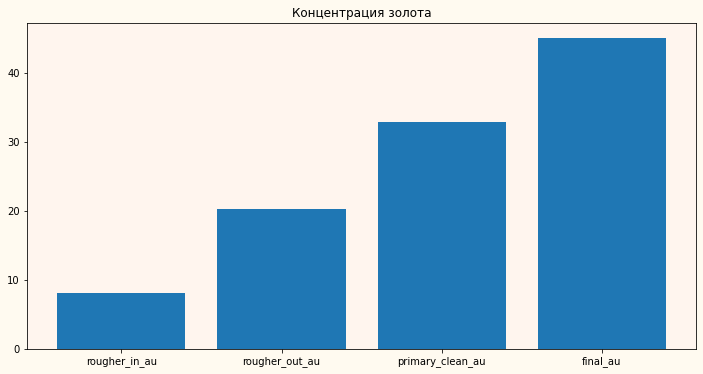

In [44]:
buildBar(concentrate_au, 'Концентрация золота')

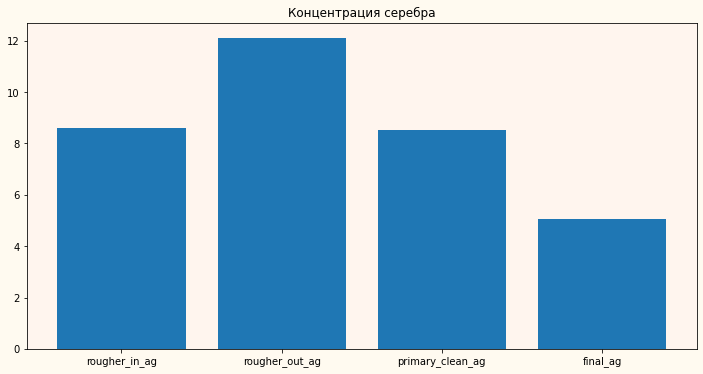

In [45]:
buildBar(concentrate_ag, 'Концентрация серебра')

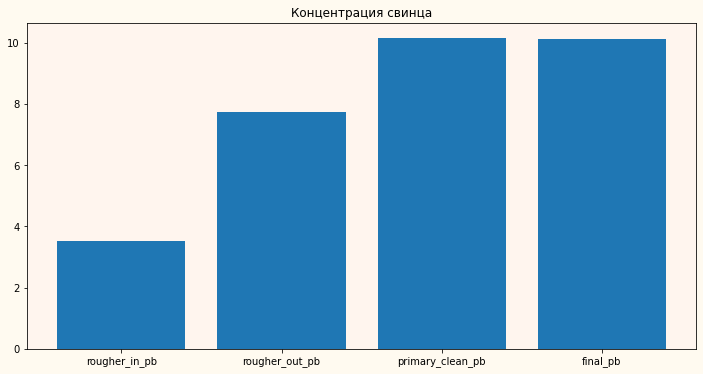

In [46]:
buildBar(concentrate_pb, 'Концентрация свинца')

**Выводы**

По графикам видим, что концентрация золота увеличивается на каждом из этапов, концентрация серебра сначала увеличивается после этапа флотации и потом уменьшается на каждом следующем этапе, а концентрация свинца увеличивается до этапа второй очистки и потом немного уменьшается. При этом в продукте на выходе концентрация золота достигает порядка 45 единиц, серебра - порядка 5 единиц, а свинца - порядка 10 единиц (по медиане).

### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

In [47]:
# сохраним данные о размерах гранул сырья на обучающей выборке в переменную `feed_size_train`
feed_size_train = df_train.loc[:,'rougher.input.feed_size']
feed_size_train.head()

0    55.486599
1    57.278666
2    57.510649
3    57.792734
4    56.047189
Name: rougher.input.feed_size, dtype: float64

In [48]:
# сохраним данные о размерах гранул сырья на тестовой выборке в переменную `feed_size_test`
feed_size_test = df_test.loc[:,'rougher.input.feed_size']
feed_size_test.head()

0    62.710452
1    61.961163
2    66.903807
3    59.865919
4    63.315324
Name: rougher.input.feed_size, dtype: float64

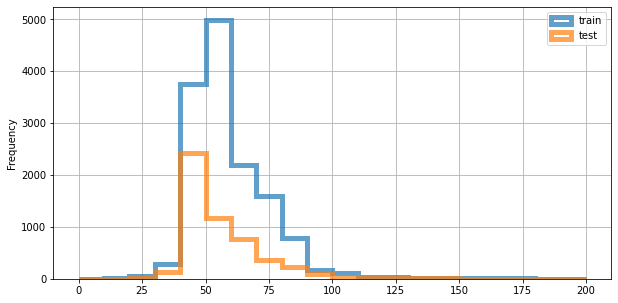

In [49]:
# сравним распределение размерах гранул сырья для обучающей и тестовой выборок
ax = feed_size_train.plot(
    kind='hist',
    histtype='step',
    range=(0, 200),
    bins=20,
    linewidth=5,
    alpha=0.7,
    label='train',
    grid=True,
    legend=True,
    figsize=(10,5)
)

feed_size_test.plot(
    kind='hist',
    histtype='step',
    range=(0, 200),
    bins=20,
    linewidth=5,
    alpha=0.7,
    label='test',
    ax=ax,
    grid=True,
    legend=True,
    figsize=(10,5)
);

**Выводы**

По графику видно что большинство объектов в обучающей выборке иммет размер гранул сырья 50-60 единиц, а в тестовой выборке - 40-50 единиц. Распределение не сильно отличаются друг от друга, оценка модели будет правильной.

### Исследование суммарной концентрации всех веществ на разных стадиях

In [50]:
# сохраним данные по кончентрациям всех веществ на разных этапах в переменную `concentrate`
concentrate = df_full.loc[:,df_full.columns.str.contains('concentrate')]
concentrate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 13 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   final.output.concentrate_ag                    19439 non-null  float64
 1   final.output.concentrate_pb                    19439 non-null  float64
 2   final.output.concentrate_sol                   19439 non-null  float64
 3   final.output.concentrate_au                    19439 non-null  float64
 4   primary_cleaner.output.concentrate_ag          19439 non-null  float64
 5   primary_cleaner.output.concentrate_pb          19439 non-null  float64
 6   primary_cleaner.output.concentrate_sol         19439 non-null  float64
 7   primary_cleaner.output.concentrate_au          19439 non-null  float64
 8   rougher.calculation.sulfate_to_au_concentrate  19439 non-null  float64
 9   rougher.output.concentrate_ag                  194

In [51]:
# удалим расчётный тсолбец `rougher.calculation.sulfate_to_au_concentrate`
concentrate = concentrate.drop('rougher.calculation.sulfate_to_au_concentrate', axis=1)
concentrate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 12 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   final.output.concentrate_ag             19439 non-null  float64
 1   final.output.concentrate_pb             19439 non-null  float64
 2   final.output.concentrate_sol            19439 non-null  float64
 3   final.output.concentrate_au             19439 non-null  float64
 4   primary_cleaner.output.concentrate_ag   19439 non-null  float64
 5   primary_cleaner.output.concentrate_pb   19439 non-null  float64
 6   primary_cleaner.output.concentrate_sol  19439 non-null  float64
 7   primary_cleaner.output.concentrate_au   19439 non-null  float64
 8   rougher.output.concentrate_ag           19439 non-null  float64
 9   rougher.output.concentrate_pb           19439 non-null  float64
 10  rougher.output.concentrate_sol          19439 non-null  fl

In [52]:
# переименуем столбцы для удобства работы с данными
concentrate.columns

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
       'rougher.output.concentrate_sol', 'rougher.output.concentrate_au'],
      dtype='object')

In [53]:
concentrate.columns = ['final_ag', 'final_pb', 'final_sol', 'final_au',
       'primary_cleaner_ag', 'primary_cleaner_pb', 'primary_cleaner_sol', 'primary_cleaner_au',
       'rougher_ag', 'rougher_pb', 'rougher_sol', 'rougher_au']
concentrate.head()

,final_ag,final_pb,final_sol,final_au,primary_cleaner_ag,primary_cleaner_pb,primary_cleaner_sol,primary_cleaner_au,rougher_ag,rougher_pb,rougher_sol,rougher_au
0,6.055403,9.889648,5.507324,42.192020,8.547551,10.389648,19.529297,34.174427,11.500771,7.101074,28.029297,19.793808
1,6.029369,9.968944,5.257781,42.701629,8.558743,10.497069,19.369147,34.118526,11.615865,7.278807,28.067063,20.050975
2,6.055926,10.213995,5.383759,42.657501,8.603505,10.354494,19.167579,33.969464,11.695753,7.216833,27.454037,19.737170
3,6.047977,9.977019,4.858634,42.689819,7.221879,8.496563,15.978538,28.260743,11.915047,7.175616,27.341277,19.320810
4,6.148599,10.142511,4.939416,42.774141,9.089428,9.986786,19.199864,33.044932,12.411054,7.240205,27.041023,19.216101


In [54]:
concentrate['rougher'] = (
    concentrate[['rougher_ag', 'rougher_pb', 'rougher_sol', 'rougher_au']]
    .apply(lambda row: row.sum(), axis=1)
)
concentrate.head()

,final_ag,final_pb,final_sol,final_au,primary_cleaner_ag,primary_cleaner_pb,primary_cleaner_sol,primary_cleaner_au,rougher_ag,rougher_pb,rougher_sol,rougher_au,rougher
0,6.055403,9.889648,5.507324,42.192020,8.547551,10.389648,19.529297,34.174427,11.500771,7.101074,28.029297,19.793808,66.424950
1,6.029369,9.968944,5.257781,42.701629,8.558743,10.497069,19.369147,34.118526,11.615865,7.278807,28.067063,20.050975,67.012710
2,6.055926,10.213995,5.383759,42.657501,8.603505,10.354494,19.167579,33.969464,11.695753,7.216833,27.454037,19.737170,66.103793
3,6.047977,9.977019,4.858634,42.689819,7.221879,8.496563,15.978538,28.260743,11.915047,7.175616,27.341277,19.320810,65.752751
4,6.148599,10.142511,4.939416,42.774141,9.089428,9.986786,19.199864,33.044932,12.411054,7.240205,27.041023,19.216101,65.908382


In [55]:
concentrate['primary_cleaner'] = (
    concentrate[['primary_cleaner_ag', 'primary_cleaner_pb', 'primary_cleaner_sol', 'primary_cleaner_au']]
    .apply(lambda row: row.sum(), axis=1)
)
concentrate.head()

,final_ag,final_pb,final_sol,final_au,primary_cleaner_ag,primary_cleaner_pb,primary_cleaner_sol,primary_cleaner_au,rougher_ag,rougher_pb,rougher_sol,rougher_au,rougher,primary_cleaner
0,6.055403,9.889648,5.507324,42.192020,8.547551,10.389648,19.529297,34.174427,11.500771,7.101074,28.029297,19.793808,66.424950,72.640924
1,6.029369,9.968944,5.257781,42.701629,8.558743,10.497069,19.369147,34.118526,11.615865,7.278807,28.067063,20.050975,67.012710,72.543485
2,6.055926,10.213995,5.383759,42.657501,8.603505,10.354494,19.167579,33.969464,11.695753,7.216833,27.454037,19.737170,66.103793,72.095042
3,6.047977,9.977019,4.858634,42.689819,7.221879,8.496563,15.978538,28.260743,11.915047,7.175616,27.341277,19.320810,65.752751,59.957723
4,6.148599,10.142511,4.939416,42.774141,9.089428,9.986786,19.199864,33.044932,12.411054,7.240205,27.041023,19.216101,65.908382,71.321010


In [56]:
concentrate['final'] = (
    concentrate[['final_ag', 'final_pb', 'final_sol', 'final_au']]
    .apply(lambda row: row.sum(), axis=1)
)
concentrate.head()

,final_ag,final_pb,final_sol,final_au,primary_cleaner_ag,primary_cleaner_pb,primary_cleaner_sol,primary_cleaner_au,rougher_ag,rougher_pb,rougher_sol,rougher_au,rougher,primary_cleaner,final
0,6.055403,9.889648,5.507324,42.192020,8.547551,10.389648,19.529297,34.174427,11.500771,7.101074,28.029297,19.793808,66.424950,72.640924,63.644396
1,6.029369,9.968944,5.257781,42.701629,8.558743,10.497069,19.369147,34.118526,11.615865,7.278807,28.067063,20.050975,67.012710,72.543485,63.957723
2,6.055926,10.213995,5.383759,42.657501,8.603505,10.354494,19.167579,33.969464,11.695753,7.216833,27.454037,19.737170,66.103793,72.095042,64.311180
3,6.047977,9.977019,4.858634,42.689819,7.221879,8.496563,15.978538,28.260743,11.915047,7.175616,27.341277,19.320810,65.752751,59.957723,63.573449
4,6.148599,10.142511,4.939416,42.774141,9.089428,9.986786,19.199864,33.044932,12.411054,7.240205,27.041023,19.216101,65.908382,71.321010,64.004667


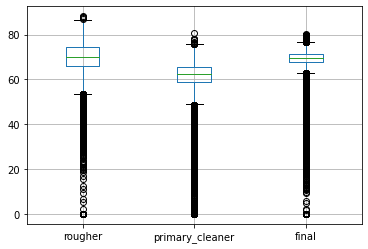

In [57]:
# проверим на выбросы значения в столбцах `rougher`, `primary_cleaner` и `final`, построим boxplot
boxplot = concentrate.boxplot(column=['rougher', 'primary_cleaner', 'final'])

По графику видно, что на каждом из этапов имеются аномальные значения суммарной концентрации веществ. Нулевые и около нулевые значения концентраций это явная аномалия. Скорее всего это связано со сбоем измерительного оборудования. Модель планируется использовать для подбора параметров оборудования, поэтому примеры со сбоями не интересные для моделирования. Такие наблюдения нужно удалить из данных.

Чтобы удалить нулевые и около нулевые значения концентраций в обучающей выборке добавим в неё также столбцы с суммарными концентрациями по этапам. В тестовой выборке столбцов с концентрациями нет.

In [58]:
# добавим суммарные концентрации по этапам в обучающую выборку
df_train['rougher_conc'] = df_train[['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
       'rougher.output.concentrate_sol', 'rougher.output.concentrate_au']].apply(lambda row: row.sum(), axis=1)

df_train['prim_clean_conc'] = df_train[['primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au']].apply(lambda row: row.sum(), axis=1)

df_train['final_conc'] = df_train[['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au']].apply(lambda row: row.sum(), axis=1)

df_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher_conc,prim_clean_conc,final_conc
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,66.424950,72.640924,63.644396
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927

In [59]:
# уберем из таблицы строки со значениями суммарных концентраций меньше 1
df_train = df_train.query('rougher_conc > 1').reset_index(drop=True)
df_train = df_train.query('prim_clean_conc > 1').reset_index(drop=True)
df_train = df_train.query('final_conc > 1').reset_index(drop=True)
df_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher_conc,prim_clean_conc,final_conc
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,66.424950,72.640924,63.644396
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927

In [60]:
# проверим, что значений < 1 не осталось
len(df_train.query('final_conc < 1'))

0

### Выводы

На этапе Исследовательский анализ данных мы:
1. проанализировали концентрации металлов (Au, Ag, Pb) на различных этапах очистки - концентрация золота увеличивается на каждом из этапов, концентрация серебра уменьшается начиная с этапа флотации, а концентрация свинца увеличивается до этапа второй очистки и немного уменьшается после неё;
2. сравненили распределения размеров гранул сырья на обучающей и тестовой выборках - распределение не сильно отличаются друг от друга, не должно быть влияния на результаты работы моделей;
3. исследовали суммарную концентрацию всех веществ на разных стадиях - выявили аномалии в данных по всем веществам, удалили нулевые и около нулевые значения из обучающей выборки.

## Построение и обучение модели

### Функция для вычисления sMAPE

По условиям задачи sMAPE (англ. Symmetric Mean Absolute Percentage Error) - «симметричное среднее абсолютное процентное отклонение». Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных.

In [61]:
def SMAPE(target, predict):
    dif_abs = (abs(target - predict)) / ((abs(target) + abs(predict)) / 2)
    return (dif_abs.sum() / len(dif_abs)) * 100

In [62]:
# проверим работу фнукции
target = pd.Series([98.24,  97.77,  95.56,  99.49, 101.4 , 105.35,  95.83,  93.02])
predict = pd.Series([101.67, 102.27,  97.01, 103.46, 100.76, 101.19,  99.11,  97.59])

print(SMAPE(target, predict))

3.2713238238748077


### Модель для прогнозирования эффективности обогащения чернового концентрата

Для прогнозирования эффективности обогащения чернового концентрата нам необходмы признаки только для этапа флотации, выделим их в отдельные переменные, при этом возьмём только те признаки, которые есть в тестовой выборке. Целевой признак для этого этапа `rougher.output.recovery`, поэтому мы будем подбирать модель для решения задачи регрессии. Из обучающей выборки не будем выделять валидационную, так как будем оценивать качество моделей кросс-валидацией.

In [63]:
# сохраним признаки для этапа флотации из тестовой выборки в переменную `rougher_test`
rougher_test = df_test.loc[:,df_test.columns.str.contains('rougher')]
display(rougher_test.head())

# сформируем таблицы с признаками, определяющими целевой признак, и целевым признаком
features_test_rough = rougher_test.drop(['rougher.output.recovery'], axis=1)
target_test_rough = rougher_test['rougher.output.recovery']

# проверим размеры получившихся таблиц
print(features_test_rough.shape)
print(target_test_rough.shape)

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.output.recovery
0,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,89.993421
1,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,88.089657
2,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,88.412756
3,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.503052,1001.930679,-400.437573,950.735324,-399.802986,87.360133
4,11.327427,4.767383,488.248117,63.315324,41.269161,11.290425,13.607257,5.738081,13.650053,5.739634,996.541302,-350.562517,1304.658848,-399.511519,1306.455515,-399.050685,1248.699349,-400.876894,1058.839106,-398.988239,949.645313,-399.277632,83.236367


(5290, 22)
(5290,)


In [64]:
# сохраним названия столбцов из таблицы `features_test_rough` в переменную `features_test_name`
features_test_name = features_test_rough.columns
features_test_name

Index(['rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.feed_sol', 'rougher.input.feed_au',
       'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level'],
      dtype='object')

In [65]:
# сохраним признаки для этапа флотации из обучающей выборки в переменную `rougher_train`
rougher_train = df_train.loc[:,df_train.columns.str.contains('rougher')]
display(rougher_train.head())

# сформируем таблицы с признаками, определяющими целевой признак, и целевым признаком
features_train_rough = rougher_train.drop(['rougher.output.recovery'], axis=1)
target_train_rough = rougher_train['rougher.output.recovery']

# проверим размеры получившихся таблиц
print(features_train_rough.shape)
print(target_train_rough.shape)

,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher_conc
0,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,66.424950
1,42050.861809,3498.370979,3489.981857,2.858998,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.996163,6.012594,11.615865,7.278807,28.067063,20.050975,86.843261,4.955378,0.536689,18.965234,1.184827,1000.286398,-400.065196,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001,67.012710
2,42018.101184,3495.348910,3502.359819,2.945989,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.920305,6.204633,11.695753,7.216833,27.454037,19.737170,86.842308,4.843460,0.546416,18.808533,1.162562,999.719565,-400.074028,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147,66.103793
3,42029.447991,3498.578313,3499.162912,3.002340,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,11.630094,6.203177,11.692450,6.196578,11.915047,7.175616,27.341277,19.320810,87.226430,4.655288,0.542525,19.330200,1.079755,999.814770,-400.200179,1600.059442,-450.619948,1600.012842,-449.910497,1597.725177,-450.130127,1400.943157,-450.030142,1400.234743,-449.790835,65.752751
4,42125.354245,3494.800771,3506.679315,3.169615,6.060915,1.786875,540.531893,56.047189,34.347666,5.663707,10.957755,6.198826,10.960521,6.194897,12.411054,7.240205,27.041023,19.216101,86.688794,4.552800,0.515438,19.267422,1.012642,999.678690,-399.752729,1600.208824,-449.599614,1600.357732,-450.034364,1599.759049,-449.909799,1401.560902,-448.877187,1401.160227,-450.407128,65.908382


(13599, 35)
(13599,)


In [66]:
# оставим в таблице с признаками, определяющими целевой признак, только те, что есть в тестовой выборке
features_train_rough = features_train_rough[['rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.feed_sol', 'rougher.input.feed_au',
       'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level']]
features_train_rough.head(3)

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636
1,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.996163,6.012594,1000.286398,-400.065196,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001
2,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.920305,6.204633,999.719565,-400.074028,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147


По таблицам видим, что у признаков разный масштаб. Необходимо их стандартизировать. Используем для этого `StandardScaler`.

In [67]:
scaler = StandardScaler()

# обучим scaler на обучающей выборке
scaler.fit(features_train_rough)

# стандартизируем обучающую и тестовую выборки
features_train_rough = scaler.transform(features_train_rough)
features_test_rough = scaler.transform(features_test_rough)

С помощью make_scorer() создадим метрику для оценки качества модели на кросс-валидации.

In [68]:
my_scorer = make_scorer(SMAPE, greater_is_better=True)

Подберём значения гиперпараметров модели Дерево решений в регрессии и оценим её качество кросс-валидацией.

In [69]:
clf = DecisionTreeRegressor()

parametrs = { 'max_depth': range (1, 6),
              'min_samples_leaf': range (1, 8),
              'min_samples_split': range (2, 10, 2) }

grid = GridSearchCV(clf, parametrs, cv=5, scoring=my_scorer)
grid.fit(features_train_rough, target_train_rough)

grid.best_params_

{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 6}

Значения гиперпараметров Дерево решений в регрессии для лучшего значения SMAPE: max_depth = 1, min_samples_leaf = 1, min_samples_split = 6. Обучим модель Дерево решений в регрессии и оценитм её качество.

In [70]:
%%time
# измерим время обучения модели

model = DecisionTreeRegressor(random_state=42, max_depth=1, min_samples_leaf=1, min_samples_split=6) 
scores = cross_val_score(model, features_train_rough, target_train_rough, cv=5, scoring=my_scorer)
final_score = scores.mean()
final_score

CPU times: user 187 ms, sys: 5.26 ms, total: 193 ms
Wall time: 198 ms


7.929832157790838

Среднее значение SMAPE на обучающей выборке 7.93, время работы модели = 198 ms.

Обучим модель Линейная регрессия и оценитм её качество.

In [71]:
%%time 
# измерим время обучения модели

model = LinearRegression()
scores = cross_val_score(model, features_train_rough, target_train_rough, cv=10, scoring=my_scorer)
final_score = scores.mean()
print(f'SMAPE на обучающей выборке: {final_score}')

SMAPE на обучающей выборке: 6.024860666626165
CPU times: user 268 ms, sys: 75.8 ms, total: 344 ms
Wall time: 197 ms


Среднее значение SMAPE на обучающей выборке 6.02, время работы модели = 197 ms.

In [72]:
# составим таблицу сравнения рассчитанных значений
final = pd.DataFrame({'model': ['DecisionTreeRegressor', 'LinearRegression'], 
                      'SMAPE_rough': [7.93, 6.02],
                      'time_rough': ['198 ms', '197 ms']})
final

,model,SMAPE_rough,time_rough
0,DecisionTreeRegressor,7.93,198 ms
1,LinearRegression,6.02,197 ms


**Выводы**

На данном этапе мы проделали следующую работу:
1. подготовили сформировали таблицы с признаками, определяющими целевой признак, и целевым признаком для предсказания эффективности обогащения чернового концентрата для обучающей и тестовой выборок;
2. масштабировали значения признаков для корректной работы модели;
3. обучили разные модели и оценили их качество кросс-валидацией - лучшие показатели по совокупности значение SMAPE и время на обработку данных у модели Линейная регрессия.

### Модель для прогнозирования эффективности обогащения финального концентрата

Для прогнозирования эффективности обогащения финального концентрата нам необходмы признаки для первого и второго этапов очистки, выделим их в отдельные переменные и оставим только те, что есть в тестовой выборке. Целевой признак для этого этапа `final.output.recovery`, мы также будем подбирать модель для решения задачи регрессии. Из обучающей выборки не будем выделять валидационную, так как будем оценивать качество моделей кросс-валидацией.

In [73]:
# сформируем таблицу с признаками, определяющими целевой признакдля для этапов очистки из тестовой выборки
features_test_clean = df_test.loc[:,df_test.columns.str.contains('cleaner')]
display(features_test_clean.head())

# сформируем таблицу с целевым признаком для этапов очистки
target_test_clean = df_test['final.output.recovery']

# проверим размеры получившихся таблиц
print(features_test_clean.shape)
print(target_test_clean.shape)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,24.893998,-499.382374,14.916674,-499.862299,20.031100,-449.372570,14.013968,-449.526900,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,1399.480508,-499.374053,24.886905,-499.357375,14.979233,-500.186804,19.962364,-450.638828,14.009245,-450.022259,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


(5290, 30)
(5290,)


In [74]:
# сохраним названия столбцов из таблицы `features_test_rough` в переменную `features_test_name_clean`
features_test_name_clean = features_test_clean.columns
features_test_name_clean

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level',
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.

In [75]:
# сформируем таблицу с признаками, определяющими целевой признакдля для этапов очистки из обучающей выборки
features_train_clean = df_train.loc[:,df_train.columns.str.contains('cleaner')]
display(features_train_clean.head())

# сформируем таблицу с целевым признаком для этапов очистки
target_train_clean = df_train['final.output.recovery']

# проверим размеры получившихся таблиц
print(features_train_clean.shape)
print(target_train_clean.shape)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,125.629232,10.296251,7.25,1.002663,8.558743,10.497069,19.369147,34.118526,16.250511,3.049646,6.733907,2.353017,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,1574.479259,-498.931665,14.265474,4.592547,9.001494,2.488248,25.880539,-499.989656,23.889530,-500.372428,23.970550,-500.085473,22.085714,-499.446897,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,123.819808,11.316280,7.25,0.991265,8.603505,10.354494,19.167579,33.969464,16.491823,3.124664,6.471768,2.416800,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,1599.541515,-499.827444,14.115662,4.624775,8.842896,2.458187,26.005245,-499.929616,23.886657,-499.951928,23.913535,-499.442343,23.957717,-499.901982,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,122.270188,11.322140,7.25,0.996739,7.221879,8.496563,15.978538,28.260743,16.024359,2.960362,6.843791,2.262051,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,1600.449520,-500.052575,13.732071,4.482453,9.122857,2.322062,25.942508,-499.176749,23.955516,-499.848796,23.966838,-500.008812,23.954443,-499.944710,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,117.988169,11.913613,7.25,1.009869,9.089428,9.986786,19.199864,33.044932,16.480185,3.112100,6.550154,2.277073,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,-500.888152,1602.649541,-500.593010,14.079996,4.470737,8.871028,2.330448,26.024787,-500.279091,23.955345,-500.593614,23.985703,-500.083811,23.958945,-499.990309,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


(13599, 42)
(13599,)


In [76]:
# оставим в таблице с признаками, определяющими целевой признак, только те, что есть в тестовой выборке
features_train_clean = features_train_clean[['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level',
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_a_level',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank4_b_level',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank5_a_level',
       'secondary_cleaner.state.floatbank5_b_air',
       'secondary_cleaner.state.floatbank5_b_level',
       'secondary_cleaner.state.floatbank6_a_air',
       'secondary_cleaner.state.floatbank6_a_level']]
features_train_clean.head(3)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,1574.479259,-498.931665,25.880539,-499.989656,23.889530,-500.372428,23.970550,-500.085473,22.085714,-499.446897,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,1599.541515,-499.827444,26.005245,-499.929616,23.886657,-499.951928,23.913535,-499.442343,23.957717,-499.901982,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


По таблицам также видим, что у признаков разный масштаб. Необходимо их стандартизировать. Используем для этого `StandardScaler`.

In [77]:
scaler = StandardScaler()

# обучим scaler на обучающей выборке
scaler.fit(features_train_clean)

# стандартизируем обучающую и тестовую выборки
features_train_clean = scaler.transform(features_train_clean)
features_test_clean = scaler.transform(features_test_clean)

Подберём значения гиперпараметров модели Дерево решений в регрессии и оценим её качество кросс-валидацией.

In [78]:
clf = DecisionTreeRegressor()

parametrs = { 'max_depth': range (1, 6),
              'min_samples_leaf': range (1, 8),
              'min_samples_split': range (2, 10, 2) }

grid = GridSearchCV(clf, parametrs, cv=5, scoring=my_scorer)
grid.fit(features_train_clean, target_train_clean)

grid.best_params_

{'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 2}

Значения гиперпараметров Дерево решений в регрессии для лучшего значения SMAPE: max_depth = 5, min_samples_leaf = 6, min_samples_split = 2. Обучим модель Дерево решений в регрессии и оценитм её качество.

In [79]:
%%time
# измерим время обучения модели

model = DecisionTreeRegressor(random_state=42, max_depth=5, min_samples_leaf=6, min_samples_split=2) 
scores = cross_val_score(model, features_train_clean, target_train_clean, cv=5, scoring=my_scorer)
final_score = scores.mean()
final_score

CPU times: user 1.06 s, sys: 21.3 ms, total: 1.08 s
Wall time: 1.51 s


14.905513150101232

Среднее значение SMAPE на обучающей выборке 14.91, время работы модели = 1.51 s.

Обучим модель Линейная регрессия и оценитм её качество кросс-валидацией.

In [80]:
%%time 
# измерим время обучения модели

model = LinearRegression()
scores = cross_val_score(model, features_train_clean, target_train_clean, cv=10, scoring=my_scorer)
final_score = scores.mean()
print(f'SMAPE на обучающей выборке: {final_score}')

SMAPE на обучающей выборке: 9.527750090089885
CPU times: user 430 ms, sys: 80.6 ms, total: 510 ms
Wall time: 591 ms


Среднее значение SMAPE на обучающей выборке 9.53, время работы модели = 591 ms.

In [81]:
# добавим в таблицу сравнения рассчитанные значений для этапов очистки
final = pd.DataFrame({'model': ['DecisionTreeRegressor', 'LinearRegression'], 
                      'SMAPE_rough': [7.93, 6.02],
                      'time_rough': ['198 ms', '197 ms'],
                      'SMAPE_final': [14.91, 9.53],
                      'time_final': ['1.51 s', '591 ms']})
final

,model,SMAPE_rough,time_rough,SMAPE_final,time_final
0,DecisionTreeRegressor,7.93,198 ms,14.91,1.51 s
1,LinearRegression,6.02,197 ms,9.53,591 ms


**Выводы**

На данном этапе мы проделали следующую работу:
1. подготовили сформировали таблицы с признаками, определяющими целевой признак, и целевым признаком для предсказания эффективности обогащения финального концентрата для обучающей и тестовой выборок;
2. масштабировали значения признаков для корректной работы модели;
3. обучили разные модели и оценили их качество кросс-валидацией - лучшие показатели по совокупности значение SMAPE и время на обработку данных у модели Линейная регрессия.

### Вычисление итоговой sMAPE и проверка моделей на тестовой выборке

По итогам обучения разных моделей и оценки их качества лучшее значение SMAPE:
* для чернового концентрата = 6.02 (модель Линейная регрессия);
* для финального концентрата = 9.53 (модель Линейная регрессия).

Рассчитаем итоговой sMAPE на обучающей выборке.

In [82]:
print('Итоговый sMAPE на обучающей выборке =', 6.02 * 0.25 + 9.53 * 0.75)

Итоговый sMAPE на обучающей выборке = 8.6525


Проверим модели на тестовой выборке.

In [83]:
# проверим Линейную регрессию на тестовой выборке для этапа флотация
model = LinearRegression()
model.fit(features_train_rough, target_train_rough)
pred_test_rough = model.predict(features_test_rough)
SMAPE_rough_test = SMAPE(target_test_rough, pred_test_rough)

print(f'SMAPE на тестовой выборке для этапа флотация: {SMAPE_rough_test}')

SMAPE на тестовой выборке для этапа флотация: 8.231728697519184


In [85]:
# проверим Линейную регрессию на тестовой выборке для этапа очистки
model = LinearRegression()
model.fit(features_train_clean, target_train_clean)
pred_test_clean = model.predict(features_test_clean)
SMAPE_clean_test = SMAPE(target_test_clean, pred_test_clean)

print(f'SMAPE на тестовой выборке для этапа очистки: {SMAPE_clean_test}')

SMAPE на тестовой выборке для этапа очистки: 9.67337071168154


Рассчитаем итоговой sMAPE на тестовой выборке.

In [86]:
print('Итоговый sMAPE на тестовой выборке =', 8.23 * 0.25 + 9.67 * 0.75)

Итоговый sMAPE на тестовой выборке = 9.309999999999999


Для проверки адекватности работы модели сравним полученные значения sMAPE с константной моделью.

In [87]:
# проверим Константную модель на тестовой выборке для этапа флотация
my_dummy = DummyRegressor(strategy="mean")
my_dummy.fit(features_train_rough, target_train_rough)
pred_test_rough_dummy = my_dummy.predict(features_test_rough)
SMAPE_rough_test_dummy = SMAPE(target_test_rough, pred_test_rough_dummy)

print(f'SMAPE на тестовой выборке для этапа флотация: константная модель: {SMAPE_rough_test_dummy}')

SMAPE на тестовой выборке для этапа флотация: константная модель: 9.059632645438473


In [88]:
# проверим Константную модель на тестовой выборке для этапа очистки
my_dummy = DummyRegressor(strategy="mean")
my_dummy.fit(features_train_clean, target_train_clean)
pred_test_clean_dummy = my_dummy.predict(features_test_clean)
SMAPE_clean_test_dummy = SMAPE(target_test_clean, pred_test_clean_dummy)

print(f'SMAPE на тестовой выборке для этапа очистки: константная модель: {SMAPE_clean_test_dummy}')

SMAPE на тестовой выборке для этапа очистки: константная модель: 10.089689297803316


In [89]:
print('Итоговый sMAPE на тестовой выборке: константная модель =', 9.06 * 0.25 + 10.09 * 0.75)

Итоговый sMAPE на тестовой выборке: константная модель = 9.8325


**Выводы**

Значение итогового sMAPE на тестовой выборке несколько хуже, чем на обучающей, при этом в сравнении с константной моделью значение немного лучше, что позволяет сделать вывод - расчёты адекватны.

### Выводы

На этапе Построение и обучение модели мы:
1. написали функцию для вычисления эффективность обогащения sMAPE;
2. обучили разные модели, подобрали оптимальные значения гиперпараметров и оценили их качество кросс-валидацией на обучающающих выборках отдельно для каждого из этапов: получили sMAPE для чернового концентрата = 6.02 (модель Линейная регрессия) и для финального концентрата = 9.53 (модель Линейная регрессия);
3. Расчитали итоговый sMAPE для обучающей выборки = 8.65;
4. Проверили модель на тестовой выборке и расчитали итоговый sMAPE для тестовой выборки = 9.31;
5. Проверили константную модель на тестовой выборке и расчитали итоговый sMAPE = 9.83.

По итогам проделанной работы лучшая модель для для прогнозирования коэффициента восстановления золота из золотосодержащей руды - Линейная регрессия.

## Общий вывод

Исследование проводилось в четыре этапа:

* На этапе Обзор данных мы ознакомились с данными в предоставленных таблицах и зафиксировали, что в тестовой выборке отсутствует часть признаков, при этом исходный датасет содержит обучающую и тестовую выборки со всеми признаками; данные предоставлены сырыми, поэтому требуется проверка их на корректность, а также в данных содержатся пропуски;
* На этапе Предобработка данных мы проверили данные на корректность - данные корректны, восстановили в тестовой выборке таргеты, заполнили пропуски соседними значениями, проверили данные на дубликаты - дубликаты не обнаружены;
* На этапе Исследовательский анализ данных мы 
    - проанализировали концентрации металлов (Au, Ag, Pb) на различных этапах очистки - концентрация золота увеличивается, серебра - сначала увеличивается после этапа флотации и потом уменьшается на каждом следующем этапе, свинца - увеличивается до этапа второй очистки и потом немного уменьшается;
    - сравнили распределение размеров гранул сырья на обучающей и тестовой выборках - распределение не сильно отличаются друг от друга, не должно быть влияния на результаты работы моделей;
    - исследовали суммарную концентрацию всех веществ на разных стадиях - выявили аномалии в данных по всем веществам, удалили нулевые и около нулевые значения из обучающей выборки.
* На этапе Построение и обучение модели мы обучили разные модели, подобрали оптимальные значения гиперпараметров и оценили их качество кросс-валидацией на обучающающих выборках отдельно для каждого из этапов - итоговый sMAPE для обучающей выборки = 8.65, а также проверили модели на тестовой выборке и расчитали итоговый sMAPE для тестовой выборки = 9.31, и провери модель на адекватность рассчитав sMAPE для тестовой выборки на константной модели = 9.83.

На основании полученных результатов исследования наилучшей моделью для предсказания эффективности обогащения чернового концентрата на всех этапах является Линейная регрессия.